In [1]:
import pandas as pd
from pathlib import Path
from quantbt.data import get_trading_strategy_data

In [2]:
# In order to find this information you need to go under the "API and historical data" tab
# Example: https://tradingstrategy.ai/trading-view/ethereum/uniswap-v3/eth-usdc-fee-5/api-and-historical-data
pair_id = 2697765
exchange_type = "uniswap_v3"
name = "uniswap_v3-ethereum-WETH-USDC-1h"
tf = "1h"

In [1]:
# df = get_trading_strategy_data(pair_id, exchange_type, tf, "2011-11-04")
df = get_trading_strategy_data(pair_id, exchange_type, tf, "2022-11-04")
print(df)

data_directory_path = Path("./data")
if not data_directory_path.exists():
    data_directory_path.mkdir(parents=True, exist_ok=True)

df.to_parquet(f"./data/{pair_id}-{exchange_type}-{tf}.parquet")

                            open         high          low        close        volume
date                                                                                 
2022-11-04 00:00:00  1530.938107  1539.534979  1529.560951  1539.073211  1.184927e+07
2022-11-04 01:00:00  1539.073211  1542.308499  1537.073816  1537.688738  6.062660e+06
2022-11-04 02:00:00  1537.842506  1542.925515  1537.842506  1542.000084  7.568967e+06
2022-11-04 03:00:00  1542.000084  1548.954372  1538.611581  1548.954372  9.895154e+06
2022-11-04 04:00:00  1548.954372  1550.659074  1546.942140  1550.504023  4.517804e+06
...                          ...          ...          ...          ...           ...
2023-11-03 05:00:00  1791.355928  1798.355507  1789.207698  1798.355507  7.639848e+06
2023-11-03 06:00:00  1798.355507  1800.874841  1795.839696  1795.839696  4.271372e+06
2023-11-03 07:00:00  1795.839696  1800.514720  1795.301052  1798.175689  3.812614e+06
2023-11-03 08:00:00  1798.175689  1804.299585  1790.99

In [3]:
import quantbt.indicators as ind
from quantbt.strategies.S_base import S_base
from quantbt.core.enums import CommissionType, DataType, TradeSizeType
import pandas_ta as ta


data = pd.read_parquet(f"./data/{pair_id}-{exchange_type}-{tf}.parquet")
data = data[0:300]


class SMA_Cross_Strategy(S_base):
    def generate_signals(self):
        short_period, long_period = params

        data["sma_short"] = ta.sma(close=data.close, length=short_period)
        data["sma_long"] = ta.sma(close=data.close, length=long_period)
        self.sma_short = data["sma_short"]
        self.sma_long = data["sma_long"]

        self.long = ind.cross_above(self.sma_short, self.sma_long)
        self.short = ind.cross_below(self.sma_short, self.sma_long)

        return {
            "long_entries": self.long,
            "long_exits": self.short,
            "short_entries": self.short,
            "short_exits": self.long,
        }


strategy_settings = {
    "initial_capital": 100_000,
    "commission": 0.0005,
    "commission_type": CommissionType.PERCENTAGE,
    "default_trade_size": 0.2,
    "trade_size_type": TradeSizeType.PERCENTAGE,
}

st = SMA_Cross_Strategy(data, **strategy_settings)

In [4]:
# We will be doing a 5-SMA and 23-SMA crossover
params = (5, 23)
st.from_signals(params)

            equity                Date          Bid           Open   
0    100000.000000 2022-11-04 00:00:00  1539.073211  100000.000000  \
1    100000.000000 2022-11-04 01:00:00  1537.688738  100000.000000   
2    100000.000000 2022-11-04 02:00:00  1542.000084  100000.000000   
3    100000.000000 2022-11-04 03:00:00  1548.954372  100000.000000   
4    100000.000000 2022-11-04 04:00:00  1550.504023  100000.000000   
..             ...                 ...          ...            ...   
295  102811.671875 2022-11-16 07:00:00  1247.811122  102811.671875   
296  102935.890625 2022-11-16 08:00:00  1237.002790  102935.890625   
297  103047.242188 2022-11-16 09:00:00  1229.111645  103047.242188   
298  103057.335938 2022-11-16 10:00:00  1229.603363  103057.335938   
299  103057.335938 2022-11-16 11:00:00  1220.660388  103057.335938   

              High            Low          Close  
0    100000.000000  100000.000000  100000.000000  
1    100000.000000  100000.000000  100000.000000  
2    1

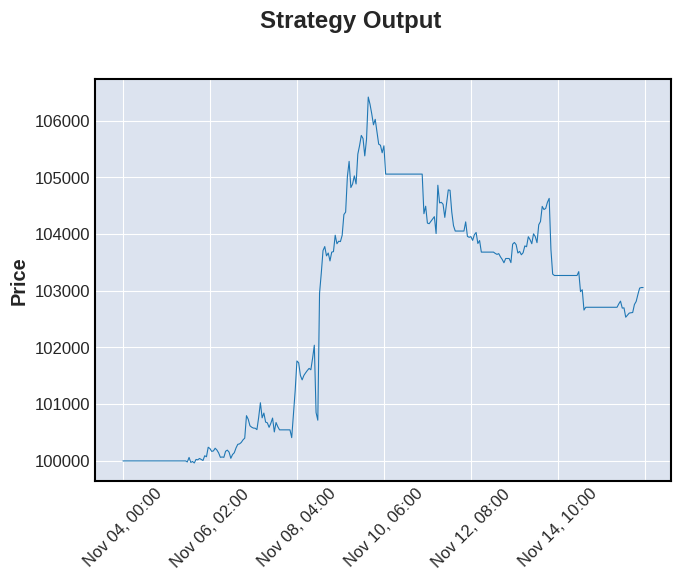

In [5]:
st.plot_equity()

In [6]:
st.get_trades()

,IDX,Index,Direction,EntryTime,EntryPrice,ExitTime,ExitPrice,Volume,SL,TSL,TP,TIME_SL,PNL,Commission,Active,CloseReason,Extra
0,0.0,36.0,0.0,2022-11-05 12:00:00,1636.037842,2022-11-07 18:00:00.000,1589.435303,12.178292,0.0,inf,0.0,inf,547.898963,19.640378,0.0,SIGNAL,-1.0
1,1.0,96.0,0.0,2022-11-08 00:00:00,1562.488403,2022-11-10 07:00:00.000,1210.934570,12.877951,0.0,inf,0.0,inf,4509.434916,17.858003,0.0,SIGNAL,-1.0
2,2.0,172.0,0.0,2022-11-11 04:00:00,1228.620117,2022-11-11 23:00:00.000,1286.067871,17.103388,0.0,inf,0.0,inf,-1004.056058,21.504843,0.0,SIGNAL,-1.0
3,3.0,196.0,0.0,2022-11-12 04:00:00,1254.567139,2022-11-12 14:00:00.000,1275.693359,16.589575,0.0,inf,0.0,inf,-371.462993,20.987974,0.0,SIGNAL,-1.0
4,4.0,213.0,0.0,2022-11-12 21:00:00,1258.210571,2022-11-13 04:00:00.000,1263.758545,16.535313,0.0,inf,0.0,inf,-112.588254,20.850775,0.0,SIGNAL,-1.0
5,5.0,222.0,0.0,2022-11-13 06:00:00,1244.322266,2022-11-14 08:00:00.000,1261.107544,16.605125,0.0,inf,0.0,inf,-299.523141,20.801489,0.0,SIGNAL,-1.0
6,6.0,261.0,0.0,2022-11-14 21:00:00,1225.430054,2022-11-15 02:00:00.000,1257.455811,16.846020,0.0,inf,0.0,inf,-560.419905,20.913373,0.0,SIGNAL,-1.0
7,7.0,284.0,0.0,2022-11-15 20:00:00,1252.060669,1969-12-31 23:59:59.999,-1.000000,16.404799,0.0,inf,0.0,inf,348.051477,20.355600,1.0,NaN,-1.0


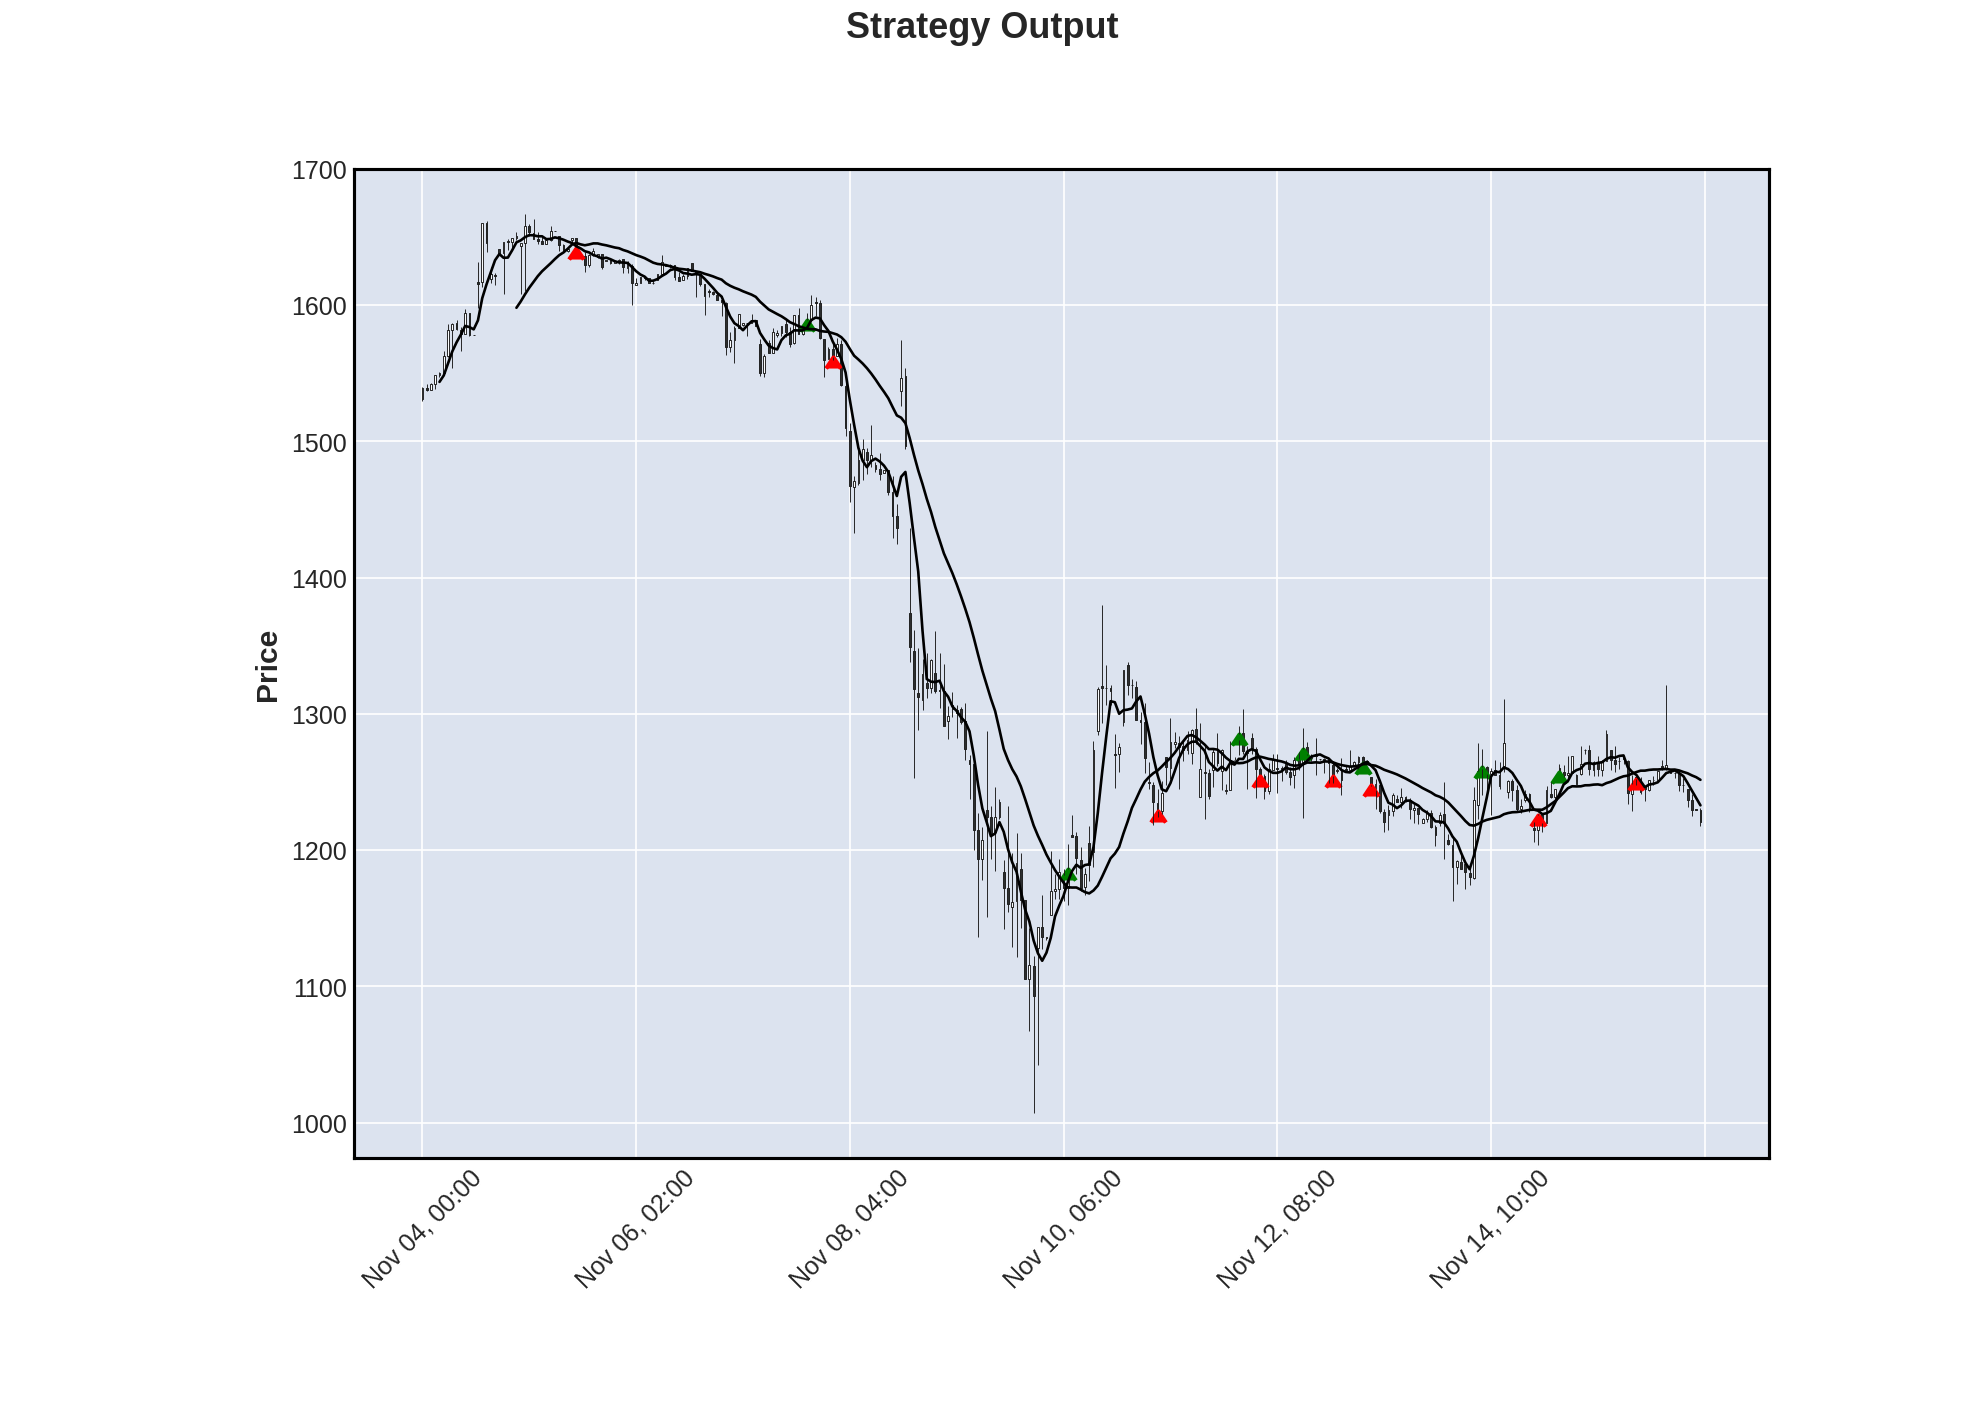

In [4]:
import matplotlib
import quantbt as qbt


plotting = qbt.lib.plotting
subplots = [
    plotting.add_line_plot(st.sma_short),
    plotting.add_line_plot(st.sma_long),
    plotting.add_markers(
        st.long, data.close, color="green", marker_type=matplotlib.markers.CARETUP
    ),
    plotting.add_markers(
        st.short, data.close, color="red", marker_type=matplotlib.markers.CARETUP
    ),
]

qbt.lib.plotting.mpf_plot(data, subplots=subplots)